In [1]:
include("../ToolBox/ToolBox.jl")
import FileIO
using .ToolBox
using .Geometry
using .Load
using Colors
import JLD

In [2]:
using Dates
using JLD
"""
    extract_datetime(SAFE_path; start_date=true)
    
    Extracts DateTime from a .SAFE file string. 

    # Arguments
    -`SAFE_path::String`: path to or name of .SAFE file
    -`start_date::Bool`: true for returning start date, false for end date.

    # Output
    - `::DateTime`: Date and time of .SAFE file

# Examples:
```jldoctest
julia> extract_datetime(S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE)
2017-03-09T05:40:35
```
"""
# SAFE_path can be path or SAFE file name, works either way.
function extract_datetime(SAFE_path; start_date=true, index=0)
    extract_SAFE_name = split(SAFE_path, "/")[end]
    if start_date
        date_string = split(extract_SAFE_name, "_")[6]
    elseif index != 0
        date_string = split(extract_SAFE_name, "_")[index]
    else
        date_string = split(extract_SAFE_name, "_")[7]
    end
    year = date_string[1:4]
    month = date_string[5:6]
    day = date_string[7:8]
    hour = date_string[10:11]
    minute = date_string[12:13]
    second = date_string[14:end]
    date_int = parse.(Int, [year, month, day, hour, minute, second])
    return DateTime(date_int...)
end

function days_between_acquisitions(date1, date2)
    return Dates.value(Date(date1) - Date(date2))
end

"""
    number_of_SAFE_files(directory)
    
    Counts all .SAFE file names in directory

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `count::Int64`: Number of .SAFE files in directory

# Examples:
```jldoctest
julia> number_of_SAFE_files(/home/directory)
30
```
"""
# counts total number of SAFE files in directory
function number_of_SAFE_files(directory)
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                count += 1
            end
        end
    end
    return count
end

"""
    all_SAFE_files(directory)
    
    returns all .SAFE file names in directory as array

    # Arguments
    -`directory::String`: path to directory

    # Output
    - `all_files::Array{String,N}`: Return .SAFE file names in Array. N is number of files

# Examples:
```jldoctest
julia> file_array = all_SAFE_files(/home/directory)
30-element Array{String,1}:
"S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
...
"S1B_IW_SLC__1SDV_20170830T053948_20170830T054014_007165_00CA0A_1DA1.SAFE"
```
"""
function all_SAFE_files(directory)
    all_files = Array{String, 1}(undef, number_of_SAFE_files(directory))
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                all_files[count + 1] = dir
                count += 1
            end
        end
    end
    return all_files
end

"""
    save_as_jld(data, file_name, file_path)

    saves input as .jld file

    # Arguments
    -`data::Any`: Saves input data
    -`file_name::String``: name of file without extension
    -`file_path::String``: path to directory

    # Output
    - None, saves file in file_path

# Examples:
```jldoctest
julia> save_as_jld(data, "data_file_name", "/home/user/result_folder")
```
"""
function save_as_jld(data, file_name, file_path)
    path = joinpath(file_path, file_name*".jld")
    JLD.save(path, "data", data)
end


function generate_id(product_folders, polarization)
    ID = Dict{String,String}()
    master_satellite = string(split(split(product_folders[1], "/")[end], "_")[1][end])
    slave_satellite = string(split(split(product_folders[2], "/")[end], "_")[1][end])

    # get last four digits in file name (identifier)
    master_safe_id = split(split(product_folders[1], "_")[end], ".")[1]
    slave_safe_id = split(split(product_folders[2], "_")[end], ".")[1]

    # compute days between acquisitions:
    master_date = replace.(string(Date(extract_datetime(product_folders[1]))),  "-" => "")
    slave_date = replace.(string(Date(extract_datetime(product_folders[2]))),  "-" => "")
    days_between_acq = string(abs(days_between_acquisitions(extract_datetime(product_folders[1]), extract_datetime(product_folders[2]))))*"d"

    # define id strings on format:            
    ID["master_id"] = "S1"*master_satellite*"_"*polarization*"_"*"M"*master_date*"_"*master_safe_id
    ID["slave_id"] = "S1"*slave_satellite*"_"*polarization*"_"*"S"*slave_date*"_"*slave_safe_id
    ID["coherence_id"] = master_satellite*slave_satellite*"_"*polarization*"_"*"M"*master_date*"_"*master_safe_id*"_"*"S"*slave_date*"_"*slave_safe_id*"_"*days_between_acq
    return ID
end


function sort_satellite_type(files, S1_selection)
    if S1_selection == "both"
        files = files[sortperm(extract_datetime.(files))]
    elseif S1_selection == "A"
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1A"]
        files = files[sortperm(extract_datetime.(files))]
    else
        files = files[hcat(split.(files, "_")...)[1, :] .== "S1B"]
        files = files[sortperm(extract_datetime.(files))]
    end
    return files
end


function save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
    
    # make stride
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)
    
    if sum(save_string .== "coherence") != 0
        println("Saving complex coherence")
        complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]
        save_as_jld(complex_coherence, ID["coherence_id"]*"_coherence", result_folder)
    end   

    if sum(save_string .== "intensity") != 0
        println("Saving intensities")
        slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
        save_as_jld(slave_intensity, ID["slave_id"]*"_intensity", result_folder)
        master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
        save_as_jld(master_intensity, ID["master_id"]*"_intensity", result_folder)
    end

    # TODO: udvid save_as_jld() til at kunne tage flere inputs måske med ...
    if sum(save_string .== "auxillary") != 0
        println("Saving auxillary data")
        lines = lines[1:stride_line:end]
        samples = samples[1:stride_sample:end]

        # save lines and samples 
        line_sample_path = joinpath(result_folder,"line_sample.jld")
        JLD.save(line_sample_path, "lines", lines, "samples", samples)

        # Save heights
        heights = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
            reshape(lut["heights"],(length(lut["master_line"]),length(lut["master_sample"])))
            ,lines, samples);

        heights_path = joinpath(result_folder,"heights.jld")
        JLD.save(heights_path, "data", heights)
        
        lut_path = joinpath(result_folder, ID["master_id"]*"_lut.jld")  # consider identifying with m and s dates
        JLD.save(lut_path, "data", lut)
    end
end


save_worker (generic function with 1 method)

In [3]:
save = false
directory = "/home/data/eigil/frame407_406"
kernel = ones(4,14)
stride_line = floor(Int,size(kernel)[1]/2)
stride_sample = floor(Int,size(kernel)[2]/2)

7

## AA pair (05/20/2017)

In [22]:
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
line_corr = 1528
sample_corr = 200
master_view = [500 + 2*line_corr:4500 + 2*line_corr, 1000 + 1*sample_corr:9000 + 1*sample_corr] # A view
#master_view = [500:4500,1200:9200]

idx = [2, 1]

polarization_array = ["VV"]
result_folder = "/home/data/eigil/results/phase_bug2_gamma_comparison"
save_string = ["coherence", "intensity", "auxillary"]

# "S1A_IW_SLC__1SDV_20170520T054038_20170520T054106_016661_01BA73_C797.SAFE"
# "S1A_IW_SLC__1SDV_20170520T054013_20170520T054040_016661_01BA73_649F.SAFE"

# "S1A_IW_SLC__1SDV_20170520T054013_20170520T054040_016661_01BA73_649F.SAFE",
# "frame407_406/S1A_IW_SLC__1SDV_20170601T054033_20170601T054101_016836_01BFD8_6FCF.SAFE"
sorted_files = [
    "S1A_IW_SLC__1SDV_20170520T054038_20170520T054106_016661_01BA73_C797.SAFE",
    "S1A_IW_SLC__1SDV_20170601T054033_20170601T054101_016836_01BFD8_6FCF.SAFE"
]

directory = "/home/data/eigil/frame407_406/"
sorted_files = joinpath.(directory, sorted_files)


product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
ID = generate_id(product_folders, "VV")

# EFTER INDEX 16 (DVS 17 og frem, B_20170607_978F) så skal man 
# skifte view i hver iteration for at få master view der passer
#if string(ID["coherence_id"])[1:2] == "AB"
#    println("AB")
#    master_view = [2000:6000,1000:9000]
#elseif string(ID["coherence_id"])[1:2] == "BA"
#    println("BA")
#    master_view = [6500:11000,2000:10000]
#end

println("Processing:")
println("Master: $(product_folders[1])")
println("Slave: $(product_folders[2])")
tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)

println("loading POD")
meta_paths = [meta_m, meta_s]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
# load DEM    
println("loading DEM")
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

Processing:
Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170601T054033_20170601T054101_016836_01BFD8_6FCF.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170520T054038_20170520T054106_016661_01BA73_C797.SAFE
loading POD
loading DEM
Coregistering slave
Mosaicking
Load master
Computing complex coherence
Saving complex coherence
Saving intensities
Saving auxillary data


In [23]:
#show(meta[1].keys)
#meta[1]["burst_count"]*meta[1]["lines_per_burst"]

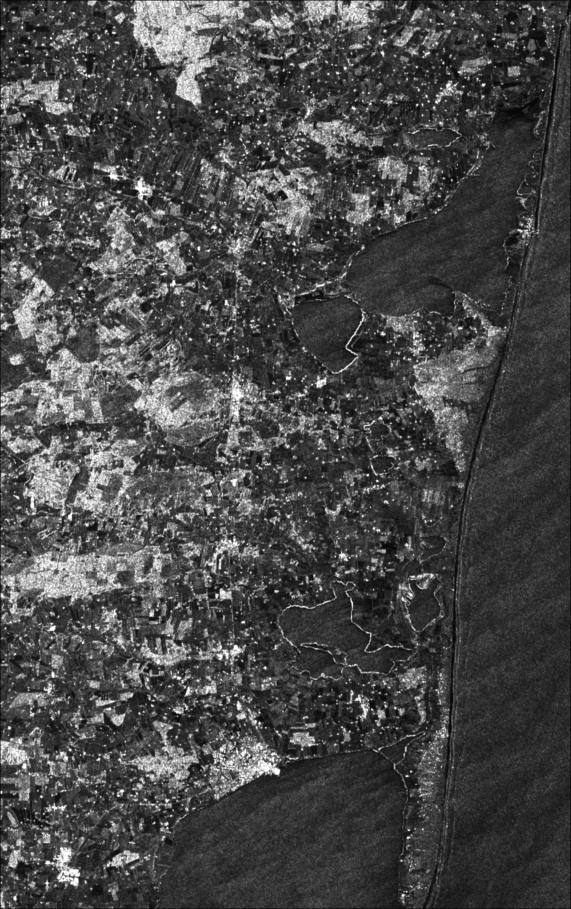

In [24]:
stride_line = floor(Int,size(kernel)[1]/2)
stride_sample = floor(Int,size(kernel)[2]/2)
SlcUtil.show_img(master_intensity[1:stride_line:end,1:stride_sample:end])

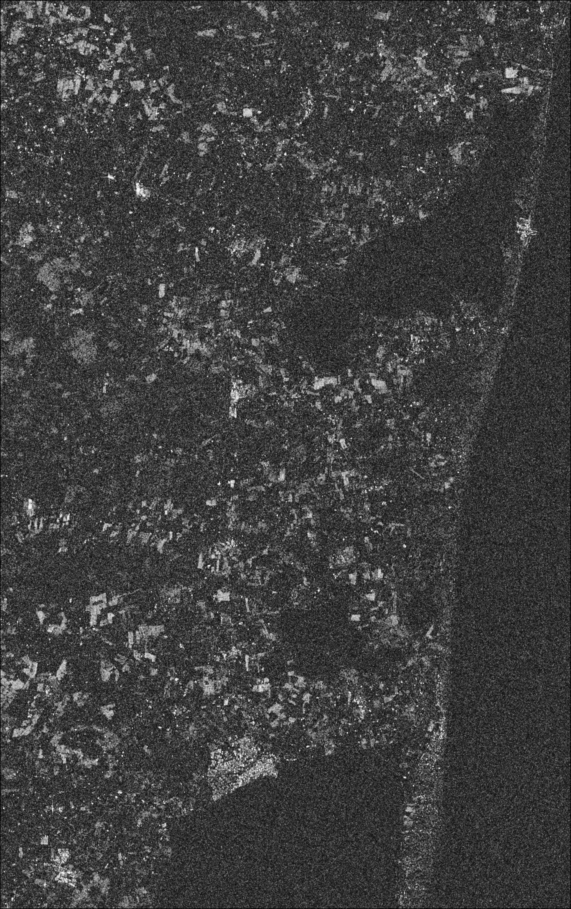

In [27]:
coherence_img = Gray.(abs.(complex_coherence[1:stride_line:end,1:stride_sample:end]))

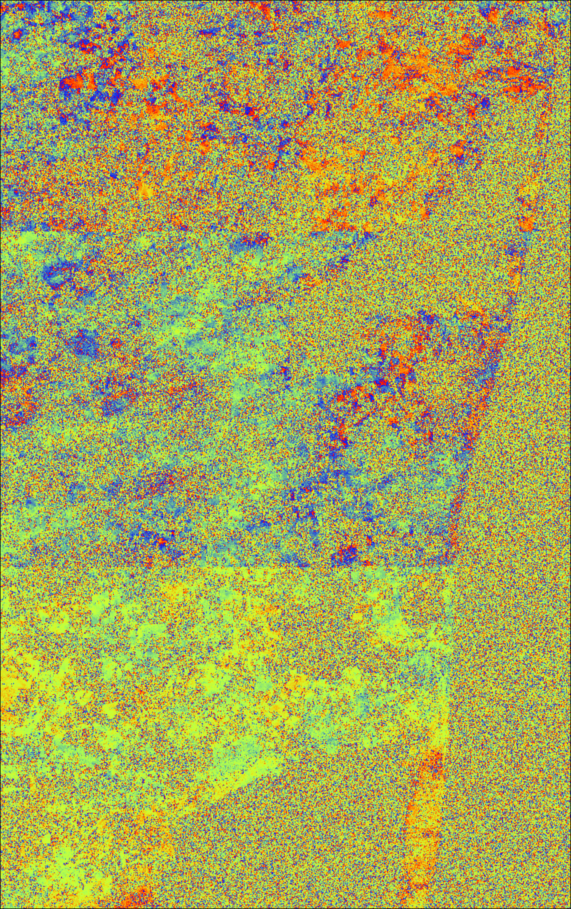

In [25]:
phase_img = SlcUtil.plot_phase(complex_coherence[1:stride_line:end,1:stride_sample:end])

## BB pair (05/20/2017)

In [4]:
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
master_view = [2000:6000,1000:9000]
idx = [2, 1]

polarization_array = ["VV"]
kernel = ones(4,14)
result_folder = "/home/data/eigil/results/phase_bug2_gamma_comparison"
save_string = ["coherence", "intensity", "auxillary"]

sorted_files = [
    "S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE",
    "S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
]

directory = "/home/data/eigil/frame407_406"
sorted_files = joinpath.(directory, sorted_files)

product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
ID = generate_id(product_folders, "VV")

println("Processing:")
println("Master: $(product_folders[1])")
println("Slave: $(product_folders[2])")
tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)

println("loading POD")
meta_paths = [meta_m, meta_s]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
# load DEM    
println("loading DEM")
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

Processing:
Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE
Slave: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE
loading POD
loading DEM
Coregistering slave
Mosaicking
Load master
Computing complex coherence
Saving complex coherence
Saving intensities
Saving auxillary data


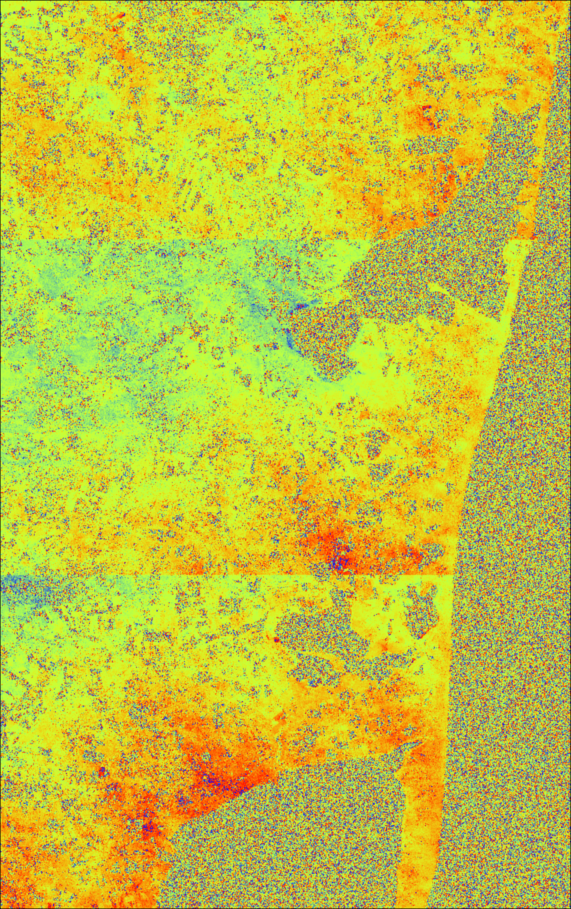

In [5]:
phase_img = SlcUtil.plot_phase(complex_coherence[1:stride_line:end,1:stride_sample:end])

## AB pair (05/20/2017)

In [9]:
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
#master_view = [2000:6000,1000:9000]
#master_view = [6500:11000,2000:10000]

line_corr = 1528
sample_corr = 200
master_view = [2000 + 4*line_corr:6000 + 4*line_corr, 1000 + 3*sample_corr:9000 + 3*sample_corr] # B view
#master_view = [500 + 2*line_corr:4500 + 2*line_corr, 1000 + 1*sample_corr:9000 + 1*sample_corr] # A view
idx = [2, 1]

polarization_array = ["VV"]
kernel = ones(4,14)
result_folder = "/home/data/eigil/results/phase_bug2_gamma_comparison"
save_string = ["coherence", "intensity", "auxillary"]

sorted_files = [
    "S1A_IW_SLC__1SDV_20170601T054033_20170601T054101_016836_01BFD8_6FCF.SAFE",
    "S1B_IW_SLC__1SDV_20170607T053943_20170607T054010_005940_00A6B7_978F.SAFE"
]

directory = "/home/data/eigil/frame407_406"
sorted_files = joinpath.(directory, sorted_files)

product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
ID = generate_id(product_folders, "VV")
println(ID)
println("Processing:")
println("Master: $(product_folders[1])")
println("Slave: $(product_folders[2])")
tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)

println("loading POD")
meta_paths = [meta_m, meta_s]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
# load DEM    
println("loading DEM")
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

Dict("slave_id" => "S1A_VV_S20170601_6FCF","coherence_id" => "BA_VV_M20170607_978F_S20170601_6FCF_6d","master_id" => "S1B_VV_M20170607_978F")
Processing:
Master: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170607T053943_20170607T054010_005940_00A6B7_978F.SAFE
Slave: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170601T054033_20170601T054101_016836_01BFD8_6FCF.SAFE
loading POD
loading DEM
Coregistering slave
Mosaicking
Load master
Computing complex coherence
Saving complex coherence
Saving intensities
Saving auxillary data


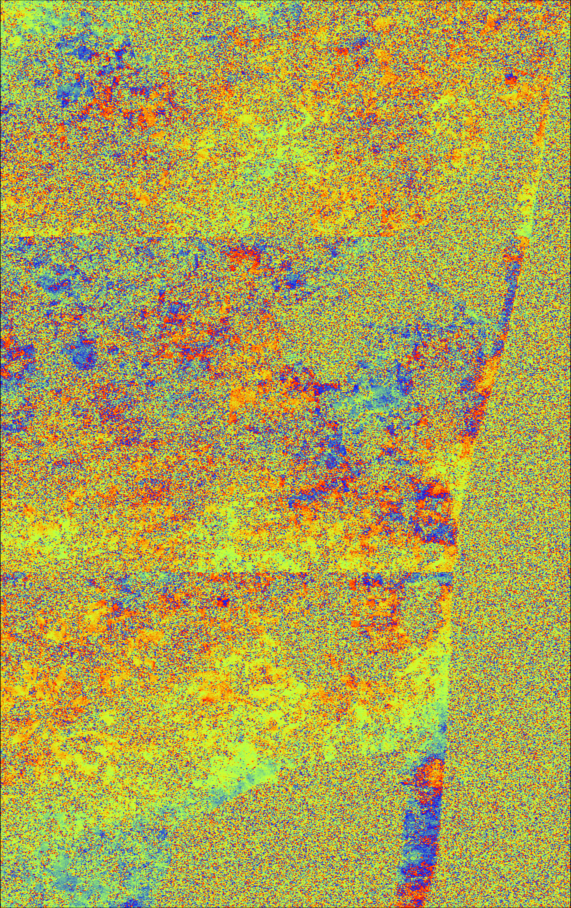

In [10]:
phase_img = SlcUtil.plot_phase(complex_coherence[1:stride_line:end,1:stride_sample:end])

## BA pair (05/20/2017)

In [11]:
pod_folder = "/home/data/eigil/POD"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"
dem_nan = 40
#master_view = [2000:6000,1000:9000]
#master_view = [6500:11000,2000:10000]
master_view = [500:4500,1200:9200] # A view
#master_view = [2000:6000,1000:9000] # B view
idx = [2, 1]

polarization_array = ["VV"]
kernel = ones(4,14)
result_folder = "/home/data/eigil/results/phase_bug2_gamma_comparison"
save_string = ["coherence", "intensity", "auxillary"]

sorted_files = [
    "S1B_IW_SLC__1SDV_20170502T053952_20170502T054020_005415_0097DA_AB1F.SAFE",
    "S1A_IW_SLC__1SDV_20170508T054037_20170508T054105_016486_01B519_75D9.SAFE"
]

directory = "/home/data/eigil/frame407_406"
sorted_files = joinpath.(directory, sorted_files)

product_folders = [sorted_files[idx[1]], sorted_files[idx[2]]]
ID = generate_id(product_folders, "VV")

println("Processing:")
println("Master: $(product_folders[1])")
println("Slave: $(product_folders[2])")
tiff_m, meta_m, calibration_m = Load.slc_paths(sorted_files[idx[1]], polarization_array[1], 3)
tiff_s, meta_s, calibration_s = Load.slc_paths(sorted_files[idx[2]], polarization_array[1], 3)

println("loading POD")
meta_paths = [meta_m, meta_s]
meta = [Load.slc_meta(path) for path in meta_paths]  # path[2] selects meta data
pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
precise_orbit = [Load.precise_orbit(pod_paths[i], meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
# load DEM    
println("loading DEM")
footprint = SlcUtil.footprint(meta[1], master_view)
latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

println("Coregistering slave")
slave_data, flat, lut =  coregister_slave(master_view, tiff_s, meta, precise_orbit, dem)

println("Mosaicking")
slave_data, mosaic_view = SlcUtil.mosaic(slave_data, master_view, meta[1]);
flat, mosaic_view = SlcUtil.mosaic(flat, master_view, meta[1]);

println("Load master")
master_data = Load.slc_data(tiff_m, master_view);
master_data,mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

println("Computing complex coherence")
complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(master_data, 
                                                                    slave_data, flat, kernel, mosaic_view);

if save
    save_worker(complex_coherence, master_intensity, slave_intensity, lines, samples, lut,
                     ID, result_folder, save_string; kernel = ones(4,14))
end

Processing:
Master: /home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170508T054037_20170508T054105_016486_01B519_75D9.SAFE
Slave: /home/data/eigil/frame407_406/S1B_IW_SLC__1SDV_20170502T053952_20170502T054020_005415_0097DA_AB1F.SAFE
loading POD
loading DEM
Coregistering slave
Mosaicking
Load master
Computing complex coherence
Saving complex coherence
Saving intensities
Saving auxillary data


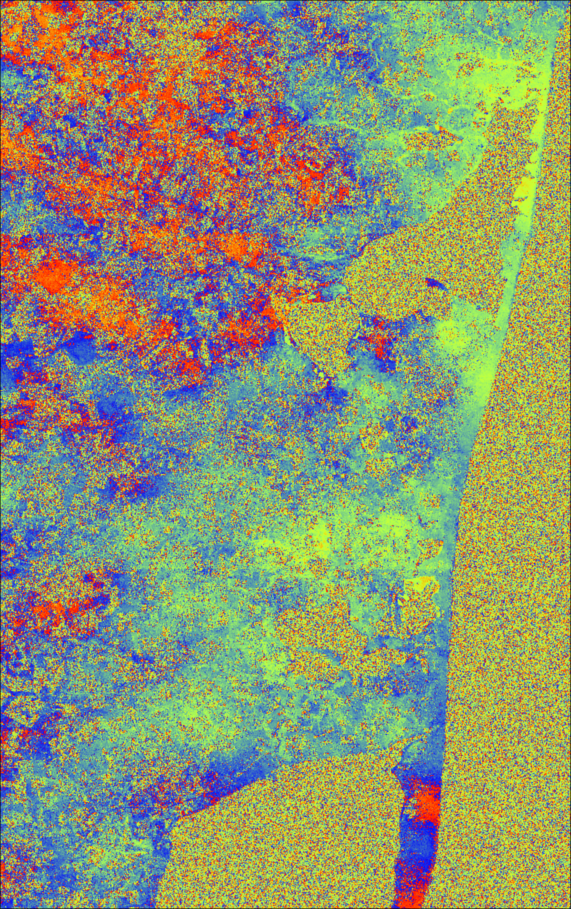

In [12]:
phase_img = SlcUtil.plot_phase(complex_coherence[1:stride_line:end,1:stride_sample:end])

In [26]:
directory = "/home/data/eigil/results/phase_bug2_gamma_comparison"
files = readdir(directory)
index = [split(split(file, ".")[1], "_")[end] == "coherence" for file in files]
files = files[index]
println(size(files))
#date_string = [split(file, "_")[3][2:end] for file in files]
#files = joinpath.(directory, files[sortperm(Date.(string.(date_string), "yyyymmdd"))])
files

(8,)


8-element Array{String,1}:
 "AA_VV_M20170520_C797_S20170601_6FCF_12d_coherence.jld"
 "AA_VV_M20170601_6FCF_S20170520_C797_12d_coherence.jld"
 "AB_VV_M20170508_75D9_S20170502_AB1F_6d_coherence.jld" 
 "AB_VV_M20170601_6FCF_S20170607_978F_6d_coherence.jld" 
 "BA_VV_M20170502_AB1F_S20170508_75D9_6d_coherence.jld" 
 "BA_VV_M20170607_978F_S20170601_6FCF_6d_coherence.jld" 
 "BB_VV_M20170408_AEEF_S20170420_3820_12d_coherence.jld"
 "BB_VV_M20170420_3820_S20170408_AEEF_12d_coherence.jld"

In [27]:
img = 0
for i in range(1, stop=length(files))
    coherence = JLD.load(directory*"/"*files[i], "data")[:, end:-1:1]
    img = SlcUtil.plot_phase(coherence)
    file_name = split(split(files[i], "/")[end], ".")[1]
    img_path = joinpath(directory*"/images", file_name*".jpg")
    FileIO.save(img_path, img);
end

In [22]:
master = 0.52 - 0.01im
slave = 0.50 - 0.02im
println(master*conj(slave))
println(slave*conj(master))

0.2602 + 0.005400000000000001im
0.2602 - 0.005400000000000001im


In [24]:
SlcUtil._phase_colorbar()

 -π                 -π/2                 0                 π/2                 π


In [ ]:
## CHECKING SOME A IMAGES
master_view = [1:13716, 1:25000]
master = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
master = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
tiff, meta, calibration = Load.slc_paths(master, "VV", 3)
VV = Load.slc_data(tiff, master_view);

SlcUtil.show_img(VV)